In [49]:
# %% [1] — Import libraries
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [50]:
# %% [2] — Load and clean data
df = pd.read_excel("dataset.xlsx")
df = df.iloc[2:]              # Skip initial metadata rows
df = df.iloc[:, :13]          # Keep only the first 13 columns
df = df.drop([2, 3, 5, 6])    # Drop irrelevant rows
df.columns = df.iloc[0]       # Set column headers
df = df.drop(4)               # Drop the row used as headers
df = df.rename(columns={"Mois Name": "Year"})
df = df.reset_index(drop=True)
df.columns.name = None

# Drop NaN years and reset index
df = df.drop([0, 1])
df = df.reset_index(drop=True)

In [51]:
# %% [3] — Reshape to time series format
df_long = df.melt(id_vars=["Year"], var_name="Month", value_name="Price")

month_map = {
    "Janvier": 1, "Février": 2, "Mars": 3, "Avril": 4, "Mai": 5, "Juin": 6,
    "Juillet": 7, "Août": 8, "Septembre": 9, "Octobre": 10, "Novembre": 11, "Décembre": 12
}
df_long["Month"] = df_long["Month"].map(month_map)
df_long["Date"] = pd.to_datetime(dict(year=df_long.Year, month=df_long.Month, day=1))

df_ts = df_long[["Date", "Price"]].sort_values("Date").reset_index(drop=True)
df_ts.set_index("Date", inplace=True)

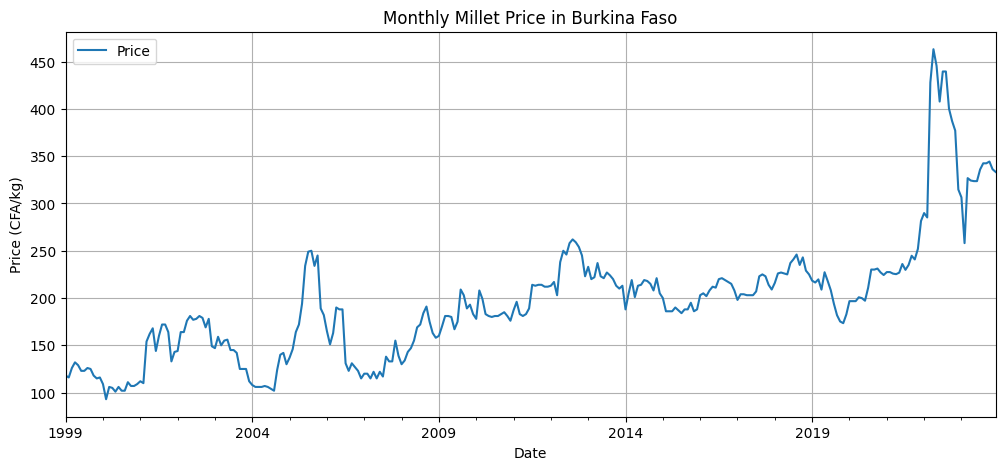

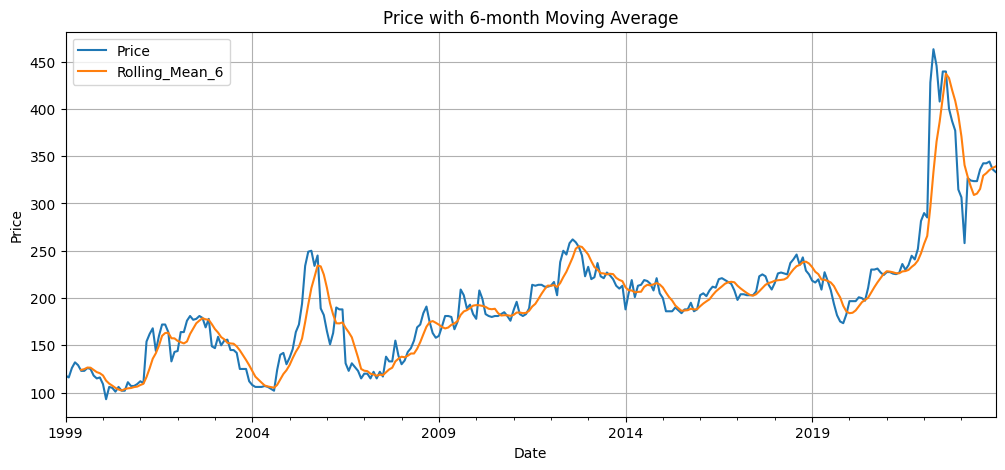

In [52]:
# %% [4] — Plot original time series and moving average
df_ts.plot(figsize=(12, 5), title="Monthly Millet Price in Burkina Faso")
plt.ylabel("Price (CFA/kg)")
plt.xlabel("Date")
plt.grid(True)
plt.show()

df_ts['Rolling_Mean_6'] = df_ts['Price'].rolling(window=6).mean()
df_ts[['Price', 'Rolling_Mean_6']].plot(figsize=(12, 5), title="Price with 6-month Moving Average")
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [53]:
# %% [5] — Time series decomposition
df_ts = df_ts.asfreq('MS')
decomposition = seasonal_decompose(df_ts['Price'], model='additive')

fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                    subplot_titles=("Observed", "Trend", "Seasonality", "Residuals"))

fig.add_trace(go.Scatter(x=decomposition.observed.index, y=decomposition.observed, name="Observed"), row=1, col=1)
fig.add_trace(go.Scatter(x=decomposition.trend.index, y=decomposition.trend, name="Trend"), row=2, col=1)
fig.add_trace(go.Scatter(x=decomposition.seasonal.index, y=decomposition.seasonal, name="Seasonal"), row=3, col=1)
fig.add_trace(go.Scatter(x=decomposition.resid.index, y=decomposition.resid, name="Residuals"), row=4, col=1)

fig.update_layout(height=900, title_text="Time Series Decomposition (Additive)",
                  showlegend=False, template="plotly_white")
fig.update_xaxes(title_text="Date", row=4, col=1)
fig.update_yaxes(title_text="Value")
fig.show()

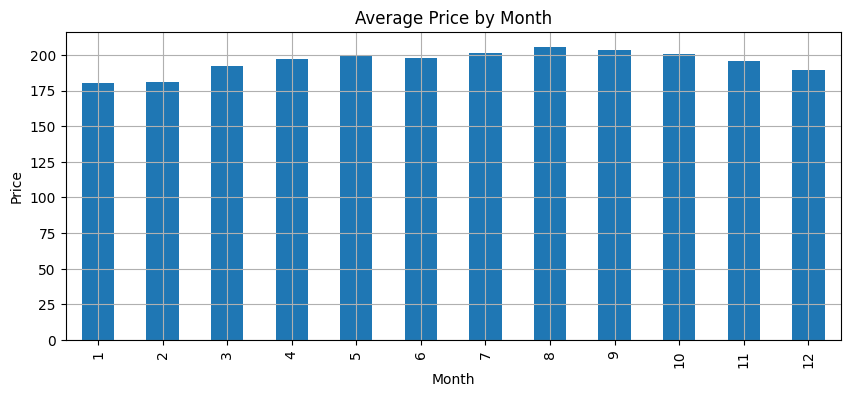

In [54]:
# %% [6] — Seasonality visualization
df_ts['Year'] = df_ts.index.year
df_ts['Month'] = df_ts.index.month

seasonality = df_ts.groupby('Month')['Price'].mean()
seasonality.plot(kind='bar', figsize=(10, 4), title="Average Price by Month")
plt.ylabel("Price")
plt.xlabel("Month")
plt.grid(True)
plt.show()


In [55]:
# %% [7] — Prepare data for LSTM
data = df_ts['Price'].values.reshape(-1, 1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 12  # 12 months
X, y = create_sequences(data_scaled, window_size)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [56]:
# %% [8] — Train LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

history = model.fit(X_train, y_train, epochs=100, batch_size=8,
                    validation_data=(X_test, y_test), verbose=1)


c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0516 - val_loss: 0.0391
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0073 - val_loss: 0.0367
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0052 - val_loss: 0.0300
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - val_loss: 0.0271
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - val_loss: 0.0241
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - val_loss: 0.0239
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0037 - val_loss: 0.0233
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - val_loss: 0.0226
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0030 - val_loss: 0.0214
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0030 - val_loss: 0.0208
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0028 - val_loss: 0.0197
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

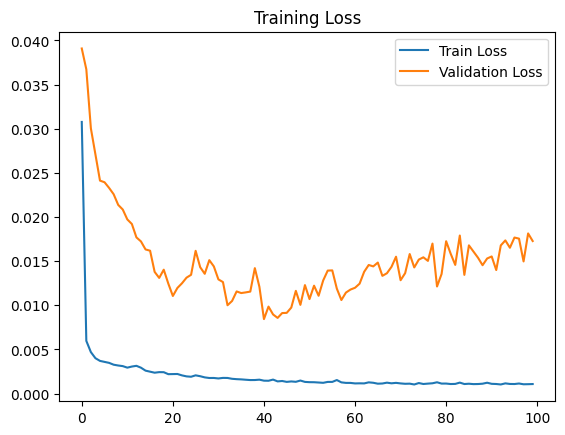

In [57]:
# %% [9] — Learning curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training Loss")
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


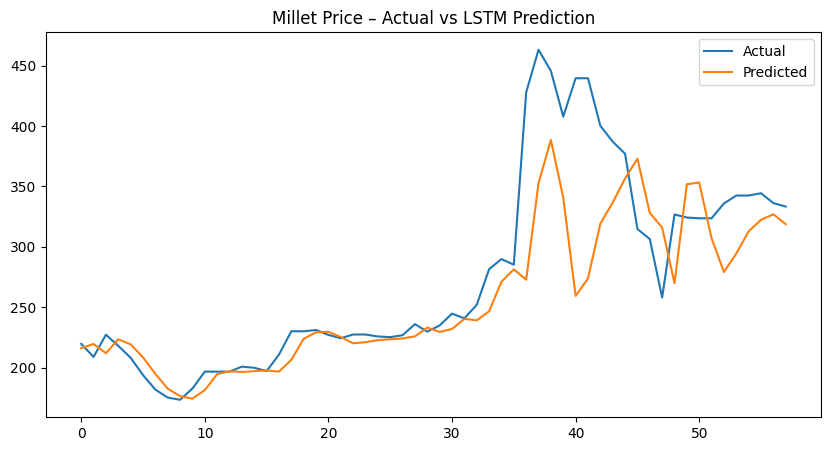

In [58]:
# %% [10] — Predictions (Test set)
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title("Millet Price – Actual vs LSTM Prediction")
plt.legend()
plt.show()


In [59]:
# %% [11] — Interactive full timeline plot (actual + prediction)
full_data_inv = scaler.inverse_transform(data_scaled)
predicted_full = np.empty_like(full_data_inv)
predicted_full[:] = np.nan
predicted_full[window_size + split:window_size + split + len(y_pred_inv)] = y_pred_inv

dates = df_ts.index

fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y=full_data_inv.flatten(), mode='lines',
                         name='Observed Price', line=dict(color='royalblue')))
fig.add_trace(go.Scatter(x=dates, y=predicted_full.flatten(), mode='lines',
                         name='LSTM Prediction', line=dict(color='orange')))

fig.update_layout(title='LSTM Price Forecast for Millet',
                  xaxis_title='Date', yaxis_title='Price (CFA/kg)',
                  template='plotly_white', height=500)
fig.show()


In [60]:
# %% [12] — Retrain on full dataset for future forecasting
data_full = df_ts['Price'].values.reshape(-1, 1)
data_scaled_full = scaler.fit_transform(data_full)

X_all, y_all = create_sequences(data_scaled_full, window_size=12)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(12, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_all, y_all, epochs=100, batch_size=8, verbose=0)

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [61]:
# %% [13] — Predict next 24 months (2024–2025)
last_sequence = data_scaled_full[-12:]
predictions_scaled = []

for _ in range(24):  # 2 years
    input_seq = last_sequence.reshape(1, 12, 1)
    next_pred = model.predict(input_seq, verbose=0)
    predictions_scaled.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)

predictions_scaled = np.array(predictions_scaled).reshape(-1, 1)
predictions = scaler.inverse_transform(predictions_scaled).flatten()

In [62]:
# %% [14] — Build forecast DataFrame
last_date = df_ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=24, freq='MS')

df_forecast = pd.DataFrame({'Date': future_dates, 'Forecast Price': predictions})
df_forecast.set_index('Date', inplace=True)


In [63]:
# %% [15] — Plot forecast (2024–2025)
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_ts.index,
    y=df_ts['Price'],
    mode='lines',
    name='Historical',
    line=dict(color='royalblue')
))

fig.add_trace(go.Scatter(
    x=df_forecast.index,
    y=df_forecast['Forecast Price'],
    mode='lines',
    name='Forecast 2024–2025',
    line=dict(color='orange', dash='dash')
))

fig.update_layout(
    title='Millet Price Forecast in Burkina Faso (2024–2025)',
    xaxis_title='Date',
    yaxis_title='Price (CFA/kg)',
    template='plotly_white',
    height=500
)

fig.show()